**FINAL CODES**

In [2]:
normal_path = "/kaggle/input/brains/Brain_Data_Organised/Normal"
stroke_path = "/kaggle/input/brains/Brain_Data_Organised/Stroke"

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.nasnet import NASNetLarge
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2025-05-22 05:00:39.389855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747890039.597487      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747890039.656553      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === 1. Load and preprocess images ===
def load_and_preprocess_images(normal_path, stroke_path, target_size=(227, 227)):
    all_images, all_labels = [], []

    for img_name in os.listdir(normal_path):
        img_path = os.path.join(normal_path, img_name)
        img = image.load_img(img_path, target_size=target_size)
        img = image.img_to_array(img)
        all_images.append(img)
        all_labels.append(0)

    for img_name in os.listdir(stroke_path):
        img_path = os.path.join(stroke_path, img_name)
        img = image.load_img(img_path, target_size=target_size)
        img = image.img_to_array(img)
        all_images.append(img)
        all_labels.append(1)

    return np.array(all_images), np.array(all_labels)

normal_path = "/kaggle/input/brains/Brain_Data_Organised/Normal"
stroke_path = "/kaggle/input/brains/Brain_Data_Organised/Stroke"

all_images, all_labels = load_and_preprocess_images(normal_path, stroke_path)
encoded_labels = to_categorical(all_labels)

# === 2. Split the dataset ===
X_train, X_test, y_train, y_test = train_test_split(all_images, encoded_labels, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# === 3. Custom CNN Architectures ===
def create_alexnet(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (11, 11), strides=4, activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    return Model(inputs=inputs, outputs=x)

def create_custom_inceptionv3(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    tower_1 = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    tower_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(tower_1)

    tower_2 = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    tower_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    tower_3 = Conv2D(64, (1, 1), activation='relu', padding='same')(tower_3)

    x = concatenate([tower_1, tower_2, tower_3], axis=-1)
    x = GlobalAveragePooling2D()(x)
    return Model(inputs, x)

def create_custom_vgg19(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    return Model(inputs, x)

def create_custom_nasnet(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    for _ in range(3):
        x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        x2 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        x = concatenate([x1, x2], axis=-1)

    x = GlobalAveragePooling2D()(x)
    return Model(inputs, x)

def create_shufflenet(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(24, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = Conv2D(144, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(144, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(288, (1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=inputs, outputs=x)

# === 4. Preprocessing function ===
def preprocess_for_model(images):
    return (images / 255.0).astype('float32')

# === 5. Feature extraction ===
def extract_features(model, images, batch_size=32):
    processed_images = preprocess_for_model(images)
    return model.predict(processed_images, batch_size=batch_size, verbose=1)

# === 6. Instantiate models ===
alexnet_model = create_alexnet()
inception_model = create_custom_inceptionv3()
vgg19_model = create_custom_vgg19()
nasnet_model = create_custom_nasnet()
shufflenet_model = create_shufflenet()

# === 7. Extract features ===
print("Extracting features from AlexNet...")
alexnet_features = extract_features(alexnet_model, X_train)
print("Extracting features from InceptionV3...")
inception_features = extract_features(inception_model, X_train)
print("Extracting features from VGG19...")
vgg19_features = extract_features(vgg19_model, X_train)
print("Extracting features from NASNet...")
nasnet_features = extract_features(nasnet_model, X_train)
print("Extracting features from ShuffleNet...")
shufflenet_features = extract_features(shufflenet_model, X_train)

# === 8. Combine and display ===
combined_features = np.concatenate([
    alexnet_features,
    inception_features,
    vgg19_features,
    nasnet_features,
    shufflenet_features
], axis=1)

print(f"\nShape of combined features: {combined_features.shape}")

I0000 00:00:1747890085.620335      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Extracting features from AlexNet...


I0000 00:00:1747890090.027189      90 service.cc:148] XLA service 0x7b10440036a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747890090.027931      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747890090.128460      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


18/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

I0000 00:00:1747890091.974584      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Extracting features from InceptionV3...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step
Extracting features from VGG19...
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step
Extracting features from NASNet...
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step
Extracting features from ShuffleNet...
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

Shape of combined features: (1400, 29792)


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
import os

# Optional: for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Assume combined_features and y_train from your previous code
X_ga_train, X_ga_val, y_ga_train, y_ga_val = train_test_split(
    combined_features, y_train, test_size=0.2, random_state=seed
)

# GA parameters
num_features = combined_features.shape[1]
population_size = 20
num_generations = 10
crossover_rate = 0.8
mutation_rate = 0.02
num_parents = 10

# Initialize population (binary chromosomes)
def initialize_population():
    return np.random.randint(0, 2, size=(population_size, num_features))

# Fitness function using a small NN
def fitness(chromosome):
    selected_indices = np.where(chromosome == 1)[0]
    if len(selected_indices) == 0:
        return 0  # avoid empty feature sets

    X_sel_train = X_ga_train[:, selected_indices]
    X_sel_val = X_ga_val[:, selected_indices]

    model = Sequential([
        Input(shape=(X_sel_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_sel_train, y_ga_train, epochs=10, batch_size=32, verbose=0)

    val_preds = model.predict(X_sel_val, verbose=0)
    acc = accuracy_score(np.argmax(y_ga_val, axis=1), np.argmax(val_preds, axis=1))
    return acc

# Select top-k parents
def select_parents(population, fitness_scores, k):
    idx = np.argsort(fitness_scores)[-k:]
    return population[idx]

# Single-point crossover
def crossover(parents):
    offspring = []
    while len(offspring) < population_size - len(parents):
        parent1, parent2 = random.sample(list(parents), 2)
        if np.random.rand() < crossover_rate:
            point = random.randint(1, num_features - 2)
            child = np.concatenate([parent1[:point], parent2[point:]])
        else:
            child = parent1.copy()
        offspring.append(child)
    return np.array(offspring)

# Mutation (bit flip)
def mutate(offspring):
    for child in offspring:
        for i in range(num_features):
            if np.random.rand() < mutation_rate:
                child[i] = 1 - child[i]
    return offspring

# Run GA
population = initialize_population()

for gen in range(num_generations):
    print(f"\n Generation {gen+1}/{num_generations}")

    fitness_scores = []
    for i, chromo in enumerate(population):
        acc = fitness(chromo)
        fitness_scores.append(acc)
        print(f"Chromosome {i+1}/{population_size} → Accuracy: {acc:.4f}")

    best_idx = np.argmax(fitness_scores)
    print(f" Best Accuracy this Gen: {fitness_scores[best_idx]:.4f}")

    parents = select_parents(population, fitness_scores, num_parents)
    offspring = crossover(parents)
    offspring = mutate(offspring)
    population = np.vstack((parents, offspring))

# Final best solution
final_fitness_scores = [fitness(chromo) for chromo in population]
best_chromosome = population[np.argmax(final_fitness_scores)]
selected_features = np.where(best_chromosome == 1)[0]

print(f"\n Total selected features: {len(selected_features)}")
print(f" Selected feature indices: {selected_features}")



 Generation 1/10
Chromosome 1/20 → Accuracy: 0.6464
Chromosome 2/20 → Accuracy: 0.6393
Chromosome 3/20 → Accuracy: 0.6393
Chromosome 4/20 → Accuracy: 0.6429
Chromosome 5/20 → Accuracy: 0.6464
Chromosome 6/20 → Accuracy: 0.6429
Chromosome 7/20 → Accuracy: 0.6429
Chromosome 8/20 → Accuracy: 0.6464
Chromosome 9/20 → Accuracy: 0.6500
Chromosome 10/20 → Accuracy: 0.6464
Chromosome 11/20 → Accuracy: 0.6429
Chromosome 12/20 → Accuracy: 0.6500
Chromosome 13/20 → Accuracy: 0.6393
Chromosome 14/20 → Accuracy: 0.6464
Chromosome 15/20 → Accuracy: 0.6393
Chromosome 16/20 → Accuracy: 0.6500
Chromosome 17/20 → Accuracy: 0.6429
Chromosome 18/20 → Accuracy: 0.6357
Chromosome 19/20 → Accuracy: 0.6464
Chromosome 20/20 → Accuracy: 0.6536
 Best Accuracy this Gen: 0.6536

 Generation 2/10
Chromosome 1/20 → Accuracy: 0.6464
Chromosome 2/20 → Accuracy: 0.6464
Chromosome 3/20 → Accuracy: 0.6500
Chromosome 4/20 → Accuracy: 0.6429
Chromosome 5/20 → Accuracy: 0.6429
Chromosome 6/20 → Accuracy: 0.6357
Chromosome 

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5028 - loss: 5.9423 - precision: 0.5028 - recall: 0.5028 - val_accuracy: 0.7071 - val_loss: 3.9210 - val_precision: 0.7071 - val_recall: 0.7071 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6380 - loss: 3.6172 - precision: 0.6380 - recall: 0.6380 - val_accuracy: 0.7464 - val_loss: 2.6631 - val_precision: 0.7464 - val_recall: 0.7464 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6676 - loss: 2.5245 - precision: 0.6676 - recall: 0.6676 - val_accuracy: 0.7071 - val_loss: 2.0869 - val_precision: 0.7071 - val_recall: 0.7071 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7150 - loss: 2.0481 - precision: 0.7150 - recall: 0.7150 - val_accuracy: 0.7250 - val_loss: 1.8307 - val_precision: 0.7250 - val_recall: 0.7250 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7

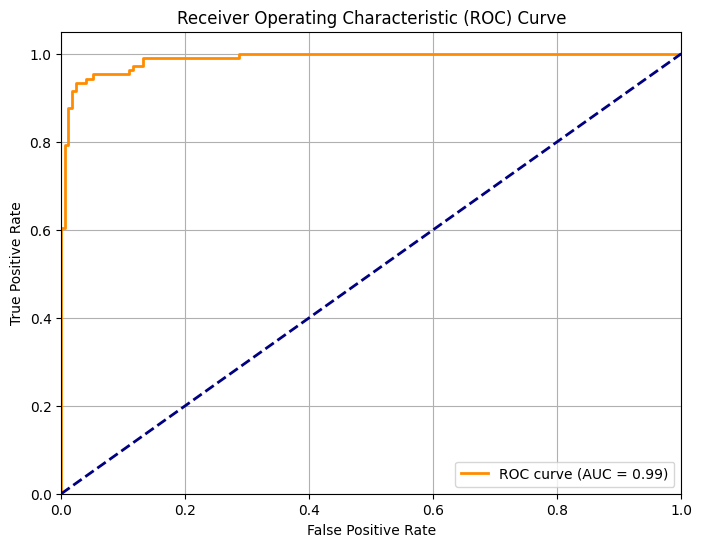

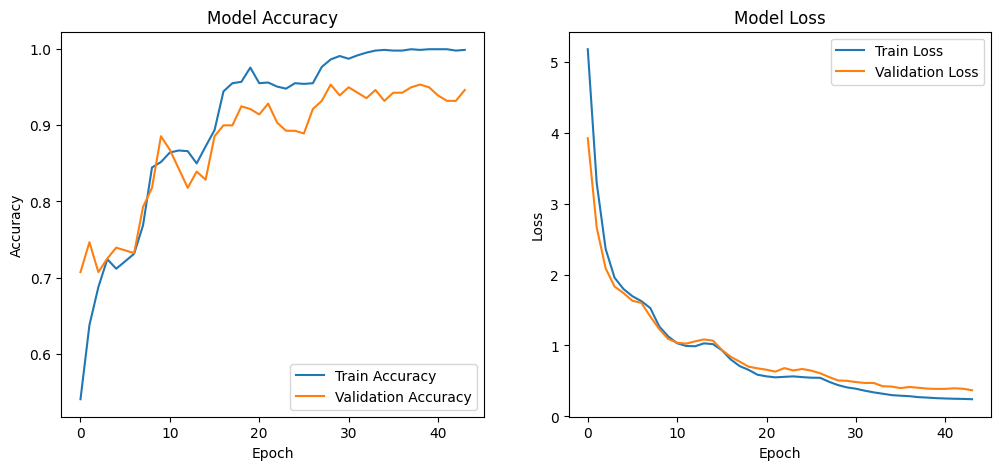

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

# === 1. Data Preparation ===
# Scale features
scaler = StandardScaler()
X_ga_train_scaled = scaler.fit_transform(X_ga_train[:, selected_features])
X_ga_val_scaled = scaler.transform(X_ga_val[:, selected_features])

# Reshape for LSTM [samples, timesteps=1, features]
X_train = X_ga_train_scaled.reshape(X_ga_train_scaled.shape[0], 1, X_ga_train_scaled.shape[1])
X_val = X_ga_val_scaled.reshape(X_ga_val_scaled.shape[0], 1, X_ga_val_scaled.shape[1])

# Class weights for imbalance
y_labels = np.argmax(y_ga_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                          classes=np.unique(y_labels), 
                                          y=y_labels)
class_weights = dict(enumerate(weights))

# === 2. LSTM Model Architecture (Matching Paper) ===
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # LSTM Layer with 64 units (as in paper)
    x = LSTM(64, 
             return_sequences=False,
             kernel_regularizer=l2(0.01),
             recurrent_regularizer=l2(0.01))(inputs)
    x = Dropout(0.3)(x)  # 30% dropout as in paper
    x = BatchNormalization()(x)
    
    # Dense Layer with 64 units (as in paper)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)  # 20% dropout as in paper
    
    # Output layer
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_lstm_model((1, X_train.shape[2]))

# === 3. Model Compilation ===
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    clipvalue=0.5  # Gradient clipping
)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# === 4. Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)
]

# === 5. Model Training ===
history = model.fit(
    X_train, y_ga_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_ga_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# === 6. Evaluation ===
val_probs = model.predict(X_val)
val_preds = np.argmax(val_probs, axis=1)
y_true = np.argmax(y_ga_val, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, val_preds, digits=4))

# Calculate metrics
accuracy = accuracy_score(y_true, val_preds)
fpr, tpr, _ = roc_curve(y_true, val_probs[:, 1])
roc_auc = auc(fpr, tpr)

print(f"\nFinal Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {roc_auc:.4f}")

# === 7. ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# === 8. Learning Curves ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5567 - loss: 10.5856 - precision: 0.5567 - recall: 0.5567 - val_accuracy: 0.7250 - val_loss: 6.5022 - val_precision: 0.7250 - val_recall: 0.7250 - learning_rate: 0.0010
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6785 - loss: 5.7640 - precision: 0.6785 - recall: 0.6785 - val_accuracy: 0.7679 - val_loss: 4.0154 - val_precision: 0.7679 - val_recall: 0.7679 - learning_rate: 0.0010
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7312 - loss: 3.7290 - precision: 0.7312 - recall: 0.7312 - val_accuracy: 0.7571 - val_loss: 3.0592 - val_precision: 0.7571 - val_recall: 0.7571 - learning_rate: 0.0010
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7167 - loss: 2.9631 - precision: 0.7167 - recall: 0.7167 - val_accuracy: 0.7821 - val_loss: 2.6226 - val_precision: 0.7821 - val_recall: 0.7821 - learning_rate: 0.0010
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy:

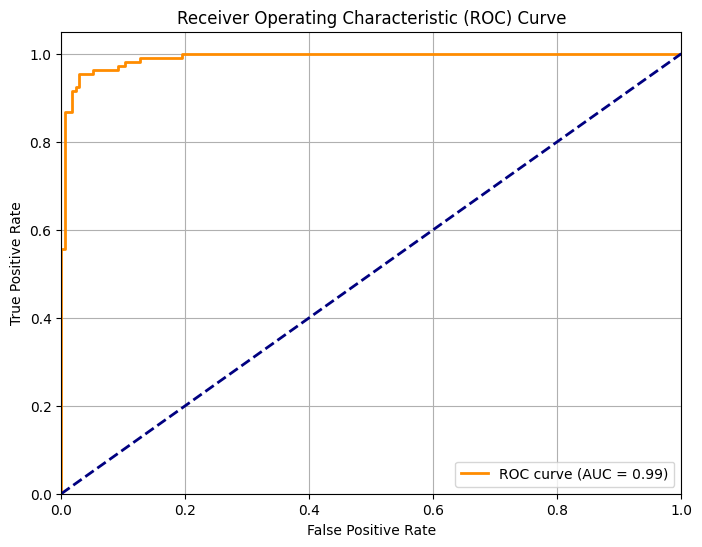

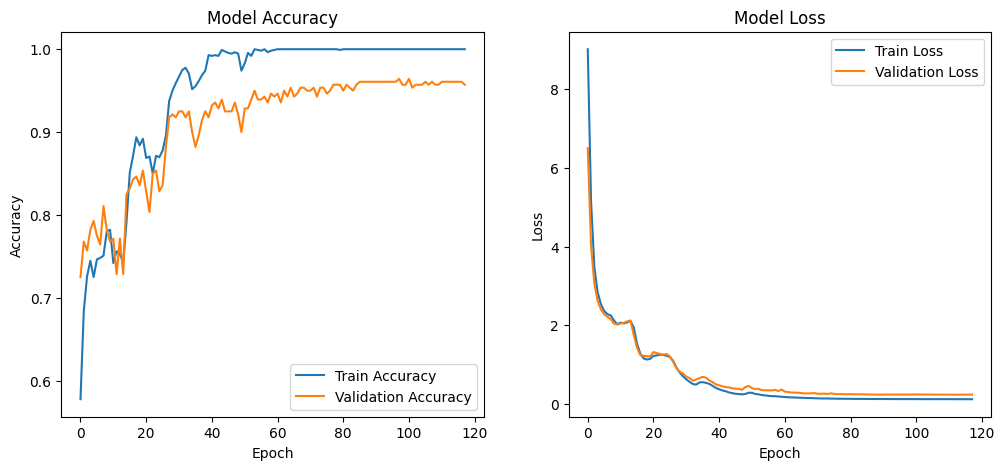

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# === 1. Data Preparation ===
scaler = StandardScaler()
X_ga_train_scaled = scaler.fit_transform(X_ga_train[:, selected_features])
X_ga_val_scaled = scaler.transform(X_ga_val[:, selected_features])

# Reshape for LSTM [samples, timesteps=1, features]
X_train = X_ga_train_scaled.reshape(X_ga_train_scaled.shape[0], 1, X_ga_train_scaled.shape[1])
X_val = X_ga_val_scaled.reshape(X_ga_val_scaled.shape[0], 1, X_ga_val_scaled.shape[1])

# Compute class weights
y_labels = np.argmax(y_ga_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_labels),
                                             y=y_labels)
class_weights = dict(enumerate(weights))

# === 2. BiLSTM Model Architecture ===
def build_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
   
    # BiLSTM Layer with regularization
    x = Bidirectional(LSTM(64,
                           return_sequences=False,
                           kernel_regularizer=l2(0.01),
                           recurrent_regularizer=l2(0.01)))(inputs)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    # Dense layer
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_bilstm_model((1, X_train.shape[2]))

# === 3. Compile Model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# === 4. Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_bilstm_model.keras', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-6)
]

# === 5. Train Model ===
history = model.fit(
    X_train, y_ga_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_ga_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# === 6. Evaluation ===
val_probs = model.predict(X_val)
val_preds = np.argmax(val_probs, axis=1)
y_true = np.argmax(y_ga_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, val_preds, digits=4))

accuracy = accuracy_score(y_true, val_preds)
fpr, tpr, _ = roc_curve(y_true, val_probs[:, 1])
roc_auc = auc(fpr, tpr)

print(f"\nFinal Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {roc_auc:.4f}")

# === 7. ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# === 8. Learning Curves ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
